<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/hooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torchvision.transforms.functional as F

In [3]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random

from google.colab import userdata

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


# 1. Set up project in runtime
Copy the following cell and run it with your credentials to clone the repo, getting datasets as runtime files, and then delete your credentials.

In [4]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/StuartLiv/CPSC-440-Project
%pwd

Cloning into 'CPSC-440-Project'...
remote: Enumerating objects: 166502, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 166502 (delta 50), reused 26 (delta 16), pack-reused 166415
Receiving objects: 100% (166502/166502), 812.39 MiB | 44.37 MiB/s, done.
Resolving deltas: 100% (37009/37009), done.
Updating files: 100% (249480/249480), done.


'/content'

# 2. Preprocess data

Datasets:
- `medset_multisize`
  - Single datasets. Dataset construction code in repo too
  - 12000 Images, in randomized order
  - Res 256x256 (grayscale images also available in 128x128, 64x64, 32x32)


In [5]:
''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  arr = []
  for i in tqdm(files):
    img = load_img(path + '/'+i)
    arr.append(img_to_array(img) / 255)

  return np.array(arr)


Load datasets, partition sets, and make tensors in color-layer order for convolutions



In [6]:
training_proportion = 0.8
validation_proportion = 0.0

def load_and_partition(path):
  arr = make_image_arr(path)
  cutoff = int(len(arr)*training_proportion)
  return arr[:cutoff], arr[cutoff:]

def make_tensor(arr):
  #Axis transformation: Shape (n, h, w, 3) -> (n, 3, h, w)
  #Inversion is np.moveaxis(arr, [2,2], [1,1])
  return torch.from_numpy(np.moveaxis(arr, [3,1], [1,2]))

#Extract single channel, since all 3 are the same in gray images
def make_gray_tensor(arr):
  return make_tensor(arr)[:, 0:1, :, :]

color_train, color_test = load_and_partition('/content/CPSC-440-Project/datasets/medset_multisize/color')
gray_train, gray_test = load_and_partition('/content/CPSC-440-Project/datasets/medset_multisize/gray')

assert(len(color_train) == len(gray_train) and len(color_test) == len(gray_test))
n_train = len(color_train)
n_test = len(color_test)

color_train_tensors = make_tensor(color_train)
color_test_tensors = make_tensor(color_test)

gray_train_tensors = make_gray_tensor(gray_train)
gray_test_tensors = make_gray_tensor(gray_test)

100%|██████████| 12000/12000 [00:11<00:00, 1059.76it/s]


1609


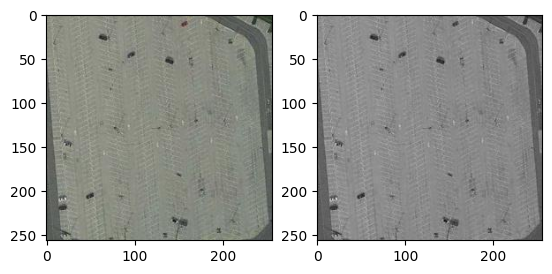

7584


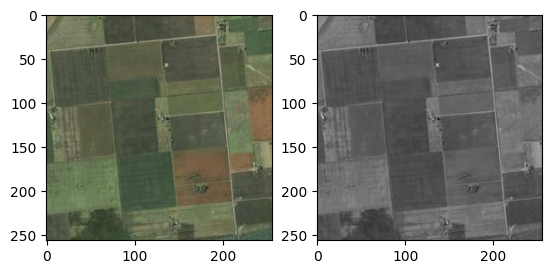

3680


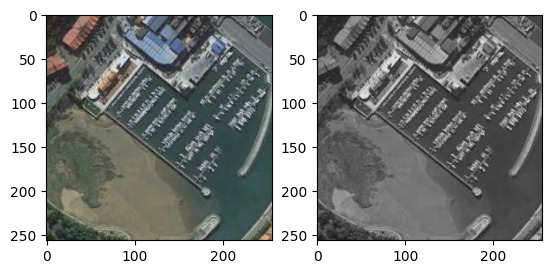

In [7]:
for i in np.random.randint(n_train,size=3):
  print(i)
  plt.subplot(1,2,1)
  plt.imshow(color_train[i])
  plt.subplot(1,2,2)
  plt.imshow(gray_train[i])
  plt.show()

# 3. Model
Model generated below:

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 3, 3, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()

Train Model (SGD)

In [9]:
autoencoder.encoder = torch.load('/content/CPSC-440-Project/models/full_size_encoder_weights_256')
autoencoder.decoder = torch.load('/content/CPSC-440-Project/models/decoder_weights_256')
autoencoder.eval()


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

## Hook
Add hooks to self.encoder or self.decoder, with the indices listed by `.eval` above!

In [10]:

# a dict to store the activations
activation = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach().cpu().numpy()
  return hook

# register forward hooks on the layers of choice
h1 = autoencoder.encoder[6].register_forward_hook(getActivation('128'))
h2 = autoencoder.encoder[13].register_forward_hook(getActivation('64'))
h3 = autoencoder.encoder[20].register_forward_hook(getActivation('32'))
# h3 = autoencoder.decoder.register_forward_hook(getActivation('sigmoid')) # this is excatly the output!


i: 1231
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT


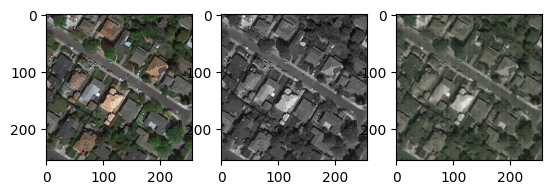

MAXPOOL ACTIVATIONS


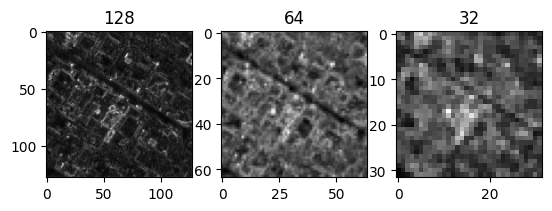

In [35]:
for i in np.random.randint(0, len(color_test), 1):
  image_bw = gray_test[i]
  image_c = color_test[i]

  # Colorize the image
  t = gray_test_tensors[i].unsqueeze(0).to(device)
  colorized_image = autoencoder(t)
  colorized_image_format = np.moveaxis(colorized_image.squeeze().cpu().detach().numpy(), [1,2], [0,1])

  print("i:", i)
  print("LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT")

  plt.subplot(1,3,1)
  plt.imshow(image_c)
  plt.subplot(1,3,2)
  plt.imshow(image_bw)
  plt.subplot(1,3,3)
  plt.imshow(colorized_image_format)
  plt.show()

  # show activations
  print('MAXPOOL ACTIVATIONS')
  j = 1
  for key in activation.keys():
    plt.subplot(1,len(activation.keys()),j)
    j += 1
    meanact = np.mean(activation[key], axis=1)
    plt.imshow(meanact[0],cmap='gray')
    plt.title(key)
  plt.show()



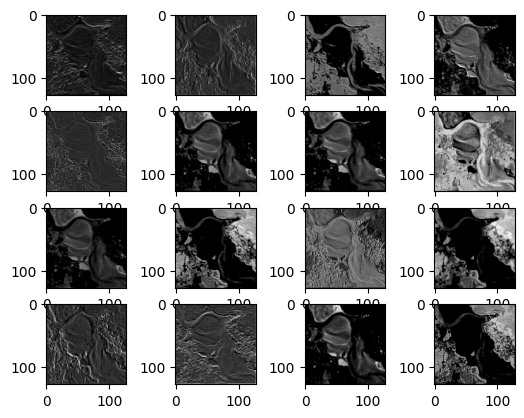

In [27]:
for channel in range(16):
  plt.subplot(4,4,channel+1)
  plt.imshow(activation['128'][0,channel],cmap='gray')
plt.show()


In [31]:
activation['128'].shape

(1, 16, 128, 128)

In [28]:
np.linalg.matrix_rank(activation['128'][0].reshape(16,-1))

16

In [29]:
U,S,V = np.linalg.svd(activation['128'][0].reshape(16,-1))

In [30]:
S

array([371.453   , 131.15187 ,  97.2147  ,  84.37302 ,  66.224434,
        49.439625,  37.37037 ,  27.966526,  22.104454,  20.230495,
        13.096981,  10.462151,   9.199728,   8.240655,   7.503648,
         6.208308], dtype=float32)

In [ ]:
np.linalg.matrix_rank(activation['128'][0].reshape(16,-1))

In [32]:
activation['64'].shape

(1, 64, 64, 64)

In [33]:
np.linalg.matrix_rank(activation['64'][0].reshape(64,-1))

64

In [36]:
U,S,V = np.linalg.svd(activation['64'][0].reshape(64,-1))
S

array([749.6479   , 180.1623   , 147.4851   , 139.67186  ,  92.563095 ,
        87.7662   ,  72.011024 ,  63.96363  ,  57.466686 ,  56.213055 ,
        55.107307 ,  51.78641  ,  49.715706 ,  46.82772  ,  46.209705 ,
        43.720455 ,  41.619267 ,  40.634693 ,  39.592487 ,  38.046467 ,
        35.915867 ,  35.538517 ,  34.24066  ,  33.88779  ,  33.097088 ,
        31.748287 ,  31.449427 ,  30.671047 ,  29.559061 ,  28.079792 ,
        27.129776 ,  26.805742 ,  26.48948  ,  25.273293 ,  24.369358 ,
        23.023458 ,  22.996004 ,  22.211609 ,  21.407173 ,  21.111334 ,
        19.870749 ,  18.949827 ,  18.742662 ,  16.949608 ,  16.495687 ,
        16.11281  ,  15.78184  ,  15.453486 ,  14.14292  ,  13.857861 ,
        13.652061 ,  13.306115 ,  11.974125 ,  11.351064 ,  11.153082 ,
        10.3026   ,   9.847168 ,   8.751108 ,   8.466456 ,   7.8438478,
         7.1473317,   6.698875 ,   5.258696 ,   5.1319714], dtype=float32)

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [16]:
cd CPSC-440-Project

/content/CPSC-440-Project


In [17]:
!git add .

In [18]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


# 4. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!